# Path setup & import packages

In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2
import sys
import os
root_path = '../../' # path to project root
sys.path.append('{}/code'.format(root_path))
sys.path.append('{}/code/core'.format(root_path))
sys.path.append('{}/code/datasets/'.format(root_path))
sys.path.insert(0,'{}/code/ptranking'.format(root_path))

from core.ranking_utils import *
from core.mallows import *
from core.ws_ranking import *
from core.ws_real_workflow import * 
from core.ws_regression import *
from core.labelling.feature_lf import *
from ptranking_wrapper import PtrankingWrapper
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import datasets_factory 
import numpy as np 
import yaml
import matplotlib.pyplot as plt
import pickle
import copy
import scipy.stats as ss
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
seed = 42
feature_drop_cols = ['vote_average',
                     'imdb_rating', 'mv_lens_avg_rating', 'tomato_user_rating',
                     'imdbId', 'movieId','tmdbId']
label_feature = 'vote_average'

# Fully supervised

In [2]:
# read data
df = pd.read_csv(os.path.join(root_path, 'data', 'movies.csv')).fillna(0)

X, Y = df.drop(feature_drop_cols, axis=1), df[label_feature]

# split data
train_fraction = 0.75
# # split data
indices_train, indices_test = train_test_split(list(range(len(Y))), train_size=train_fraction, random_state=seed)
X_train = X.iloc[indices_train]
Y_train = Y[indices_train]
X_test = X.iloc[indices_test]
Y_test = Y[indices_test]

# model declaration and fit
model = Pipeline([
    ("std", StandardScaler()),
    ("model", GradientBoostingRegressor(n_estimators=250, random_state=seed))
])
model.fit(X_train, Y_train)
Y_test_pred = model.predict(X_test)
true_mse = mean_squared_error(Y_test, Y_test_pred)
print('MSE', true_mse)

MSE 0.1925527467291617


# Weak Supervision

In [3]:
Y_mean = Y.mean() # centering for LF generation
Y_var = Y.var()

param_err, mu_err, score, mse = {}, {}, {}, {}

for m in range(3, 20):
    n = len(Y)
    L, true_Sigma = generate_lfs(m, n, Y - Y_mean, Y_var)

    lm = LabelModel()
    lm.fit(L, Y_var)
    lm.inference(L)
    Y_hat = lm.Y_hat + Y_mean

    
    Sigma_hat = lm.Sigma_hat
    param_err[m] = np.linalg.norm(Sigma_hat - true_Sigma) / (m+1)**2
    mu_err[m]    = np.linalg.norm(Sigma_hat[:m,m] - true_Sigma[:m,m]) / m
    score[m] = lm.score(Y - Y_mean)
    
    
    # # split data
    indices_train, indices_test = train_test_split(list(range(len(Y))), train_size=train_fraction, random_state=seed)
    X_train = X.iloc[indices_train]
    Y_train = Y_hat[indices_train]
    X_test = X.iloc[indices_test]
    Y_test = Y[indices_test]

    # model declaration and fit
    model = Pipeline([
        ("std", StandardScaler()),
        ("model", GradientBoostingRegressor(n_estimators=250, random_state=seed))
    ])
    model.fit(X_train, Y_train)
    Y_test_pred = model.predict(X_test)
    mse[m] = mean_squared_error(Y_test, Y_test_pred)
    print('numLFs', m, 'MSE', mse[m])

numLFs 3 MSE 0.2192718253665312
numLFs 4 MSE 0.22006232397125206
numLFs 5 MSE 0.20608877629535102
numLFs 6 MSE 0.2019596844154735
numLFs 7 MSE 0.2046691603717975
numLFs 8 MSE 0.20356031181435183
numLFs 9 MSE 0.20802179065815632
numLFs 10 MSE 0.20204556649826755
numLFs 11 MSE 0.19336314336583135
numLFs 12 MSE 0.20141611714430954
numLFs 13 MSE 0.1910425308698421
numLFs 14 MSE 0.19973201312070255
numLFs 15 MSE 0.19549025979384654
numLFs 16 MSE 0.19426991447347527
numLFs 17 MSE 0.1945735597246368
numLFs 18 MSE 0.1985990734719033
numLFs 19 MSE 0.19154206105947577


# Fully supervision with small true

In [4]:
true_small_mse = {}

for sample_percent in range(10, 60, 10):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_fraction, random_state=seed)
    sample_size = int(len(X_train) * sample_percent / 100)
    np.random.seed(seed=seed)
    sample_indices = np.random.choice(list(range(len(X_train))), size=sample_size, replace=False)
    X_train = X_train.iloc[sample_indices]
    Y_train = Y_train.iloc[sample_indices]

    # model declaration and fit
    model = Pipeline([
        ("std", StandardScaler()),
        ("model", GradientBoostingRegressor(n_estimators=250, random_state=seed))
    ])
    model.fit(X_train, Y_train)
    
    Y_test_pred = model.predict(X_test)
    true_small_mse[sample_percent] = mean_squared_error(Y_test, Y_test_pred)
    print('sample_percent', sample_percent, 'MSE', true_small_mse[sample_percent])

sample_percent 10 MSE 0.3066941946431613
sample_percent 20 MSE 0.25121418316377336
sample_percent 30 MSE 0.2289813117417758
sample_percent 40 MSE 0.22156925733452218
sample_percent 50 MSE 0.20944150631443106


# Result data handling

In [5]:
param_err = pd.Series(param_err)
mu_err = pd.Series(mu_err)
score = pd.Series(score)
mse = pd.Series(mse)

# Result visualization

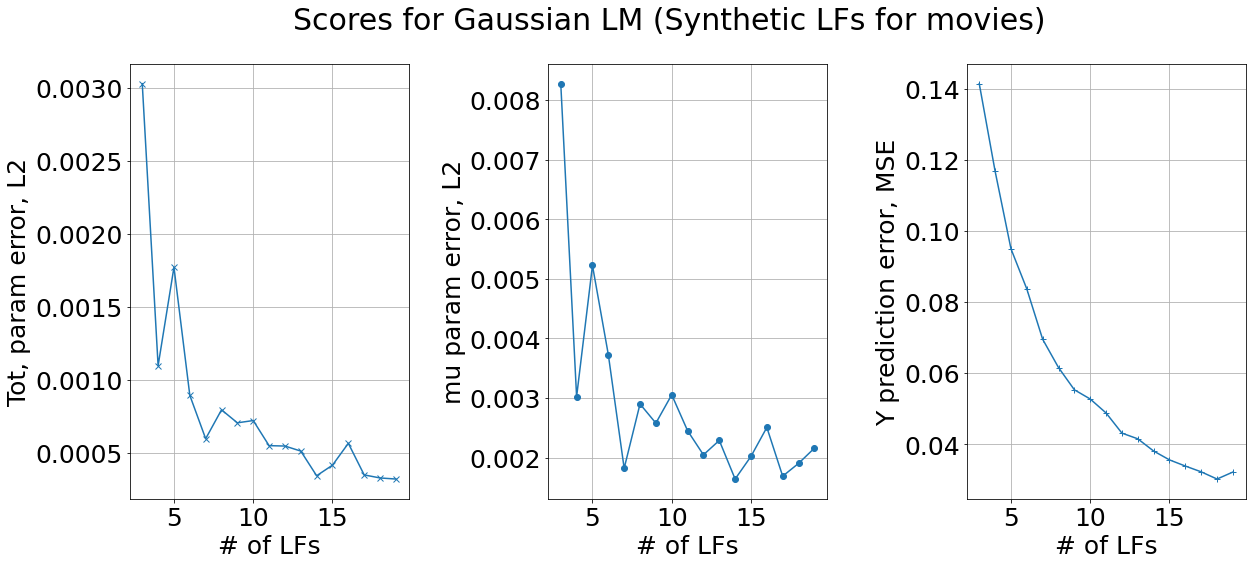

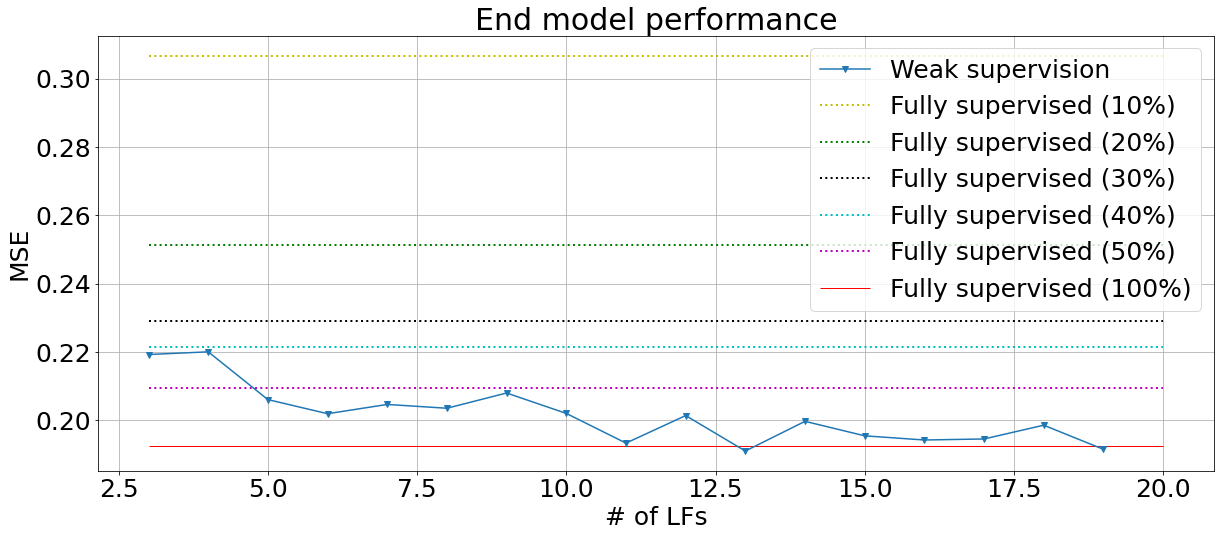

In [8]:
plt.rcParams['font.size'] = '25'

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,8))

fig.suptitle('Scores for Gaussian LM (Synthetic LFs for movies)')
ax1.plot(param_err, marker='x')
ax1.set(ylabel='Tot, param error, L2')
ax1.set(xlabel='# of LFs')
ax1.grid()
ax2.plot(mu_err, marker='o')
ax2.set(ylabel='mu param error, L2')
ax2.set(xlabel='# of LFs')
ax2.grid()
ax3.plot(score, marker='+')
ax3.set(ylabel='Y prediction error, MSE')
ax3.set(xlabel='# of LFs')
ax3.grid()
fig.subplots_adjust(wspace=.5)

fig, ax = plt.subplots(figsize=(20,8))
ax.plot(mse, marker='v', label='Weak supervision')
colors = ['y', 'g', 'k', 'c', 'm']
for i, sample_percent in enumerate(true_small_mse):
    ax.hlines(y=true_small_mse[sample_percent], linewidth=2, xmin=3, xmax=20, color=colors[i],
            linestyles='dotted', label=f'Fully supervised ({sample_percent}%)')
    
ax.hlines(y=true_mse, linewidth=1, xmin=3, xmax=20, color='r', label='Fully supervised (100%)')
ax.grid()
ax.legend()
ax.set(xlabel='# of LFs', ylabel='MSE', title='End model performance')
plt.show()